## Section 2.2 - ICP applied on moderate dataset

### Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import open3d as o3d
from tqdm import tqdm
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import matplotlib.animation as animation

!pip install ipython-autotime
%load_ext autotime

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
time: 0 ns (started: 2024-11-20 20:30:46 -03:00)


### Functions

In [2]:
def plot_2d(x, y, label, axis = None):
    if axis:
        ax = axis
    else:
        ax = plt.gca()
    ax.scatter(x,y, s=0.6)
    ax.set_ylim(-8, 8)
    ax.set_xlim(-8, 8)
    ax.plot(0, 0, 'ro')
    ax.set_title(label)
    ax.grid()
    ax.set_aspect('equal')
    if not axis:
        plt.show()
  
def kdtree_nearest_neighbor(P, Q):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src by KDTree search (faster)
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        List:
          indices of point cloud P
          indices of mathced point cloud Q
          distance
    '''
    tree = KDTree(Q.T)
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        nearest_dist, nearest_ind = tree.query([p_point], k=2)  # k=2 nearest neighbors where k1 = identity
        d = nearest_dist[:,1][0]
        j = nearest_ind[:,1][0]
        correspondences.append((i, j, d))
    return correspondences

def convert_xyz_to_pcd(input_df, output_file):
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    if 'z' not in input_df.columns:
        input_df['z']=0
    if 'ones' in input_df.columns:
        del input_df['ones']
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(input_df.to_numpy())

    # Salvar no formato .pcd
    o3d.io.write_point_cloud(output_file, pcd)

time: 0 ns (started: 2024-11-20 20:30:46 -03:00)


### Open Dataset

In [3]:
sample_i = "1"
df = pd.read_csv(f"./sample_data/t_x_y_z{sample_i}.csv", names=["time","x","y","z"], header=None)
df.tail(5)

,time,x,y,z
106920,1.731694e+09,-2.149800,-2.333729,0.0
106921,1.731694e+09,-2.198899,-2.342693,0.0
106922,1.731694e+09,-2.242859,-2.345124,0.0
106923,1.731694e+09,-2.215611,-2.272739,0.0
106924,1.731694e+09,-2.267051,-2.282449,0.0


time: 437 ms (started: 2024-11-20 20:30:46 -03:00)


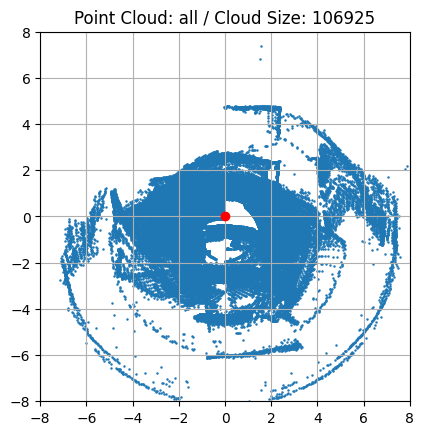

time: 219 ms (started: 2024-11-20 20:30:46 -03:00)


In [4]:
# Create scatter plot
plot_2d(df.x,df.y, f"Point Cloud: all / Cloud Size: {len(df)}")

**DATA PROBLEM #1)** Notice that we have moved the LiDAR origin over a place, we have to separate in $n$ point clouds in order to apply ICP to join them.

Since this Lidar has 6Hz, one complete rotation was done in:

$$
6 = \frac{1}{t} \rightarrow t = 0.166s
$$

**DATA PROBLEM #2)** x=0.0, y=0.0, z-0.0 sensor responses

In [5]:
# How many x=0 , y=0 points? Remember to remove these points later after cloud formation
df.loc[df['x']==0].describe()

,time,x,y,z
count,7.742000e+03,7742.0,7742.0,7742.0
mean,1.731694e+09,0.0,0.0,0.0
std,7.694971e+00,0.0,0.0,0.0
min,1.731694e+09,-0.0,-0.0,0.0
25%,1.731694e+09,0.0,0.0,0.0
50%,1.731694e+09,0.0,0.0,0.0
75%,1.731694e+09,0.0,0.0,0.0
max,1.731694e+09,-0.0,-0.0,0.0


time: 0 ns (started: 2024-11-20 20:30:46 -03:00)


**DATA PROBLEM #1 AND #2 SOLUTION)**

In [6]:
# Split the DataFrame into separate clouds
def select_frame(i):
    start_time = df.time.values[0]
    low_limit = (i-1)*0.1666+start_time
    high_limit = i*0.1666+start_time
    return df[(df['time']>low_limit) & (df['time']<high_limit)]

df2 = select_frame(1)
# n = How many blocks of cloud_size equals 1st frame size fits on the dataset?
n = int(df.index.values[-1]/len(df2))
print(f"{n} frames with {len(df2)} points each")

dfs = [select_frame(i) for i in range(1,n)]
print(f"{len(dfs)} frames with almost {len(df)//len(dfs)} points each")

# Remove x=0, y=0 points
for i in range(len(dfs)):
    idx_to_remove = dfs[i].loc[(dfs[i]['x']==0)].index.values
    dfs[i] = dfs[i].drop(index=idx_to_remove)
    idx_to_remove = dfs[i].loc[(dfs[i]['y']==0)].index.values
    dfs[i] = dfs[i].drop(index=idx_to_remove)
cloud_count = [dfs[i].x.count() for i in range(len(dfs))]
print(f"{len(dfs)} frames with almost {sum(cloud_count)//len(dfs)} points each")

161 frames with 664 points each
160 frames with almost 668 points each
160 frames with almost 618 points each
time: 156 ms (started: 2024-11-20 20:30:46 -03:00)


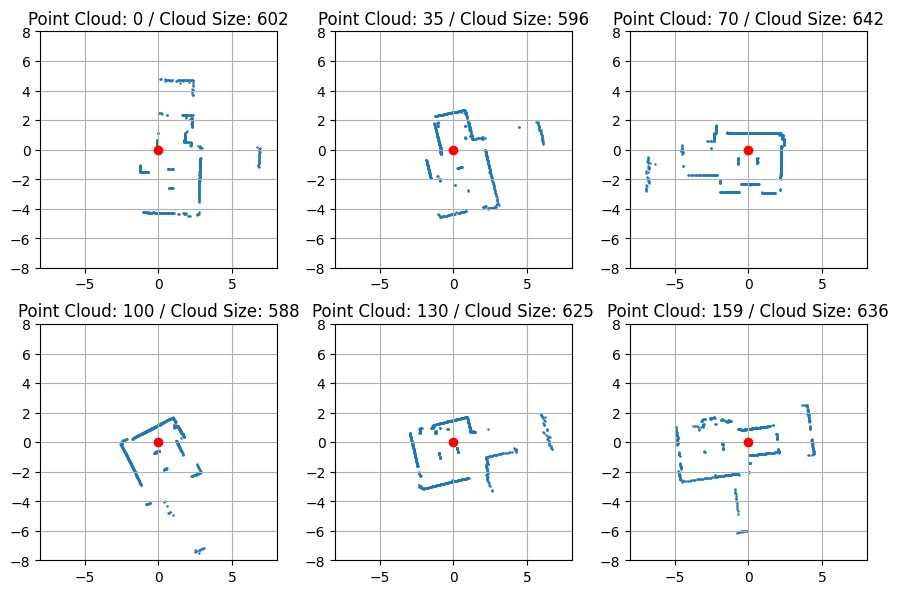

time: 578 ms (started: 2024-11-20 20:30:47 -03:00)


In [7]:
# Check different sensor responses for the same room
fig, axis = plt.subplots(2,3,figsize=(9,6))

# plot 0th point cloud
i = 0
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[0][0])

# plot 35th point cloud
i = 35
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[0][1])

# plot 70th point cloud
i = 70
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[0][2])

# plot 100th point cloud
i = 100
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[1][0])

# plot 150th point cloud
i = 130
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[1][1])

# plot 200th point cloud
i = 159
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[1][2])

plt.tight_layout()
plt.show()
cloud_size = len(df2)+1

In [8]:
# Dataset video generator
# Initialize the figure and axis
fig, ax = plt.subplots()
scatter = ax.scatter([], [], s=0.6)
ax.plot(0, 0, 'ro')
ax.set_ylim(-8, 8)
ax.set_xlim(-8, 8)
ax.set_aspect('equal')
ax.grid(True)
title = ax.set_title("")

# Update function for animation
def update(frame):
    df2 = dfs[frame]
    scatter.set_offsets(df2[['x', 'y']].values)  # Update scatter points
    title.set_text(f"Cloud: {frame + 1} / Cloud size: {len(df2)}")  # Update title
    return scatter, title

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(dfs), blit=False, repeat=False
)

# Save the animation as MP4
ani.save('imgs/scatter_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.close(fig)

time: 8.58 s (started: 2024-11-20 20:30:47 -03:00)


Result: <a href="imgs/scatter_animation.mp4">imgs/scatter_animation.mp4</a>


<video controls  height="500" >
      <source src="imgs/scatter_animation.mp4" type="video/mp4">
</video>

### Open3D ICP

#### Apply ICP between 2 (not so much) distant clouds

Initial state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.829287e-01, and correspondence_set size of 596
Access transformation to get result.

After ICP, state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.104145e-01, and correspondence_set size of 596
Access transformation to get result.
Transformation is:
[[ 0.97515401  0.22152802  0.          0.72815945]
 [-0.22152802  0.97515401  0.         -0.13779191]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


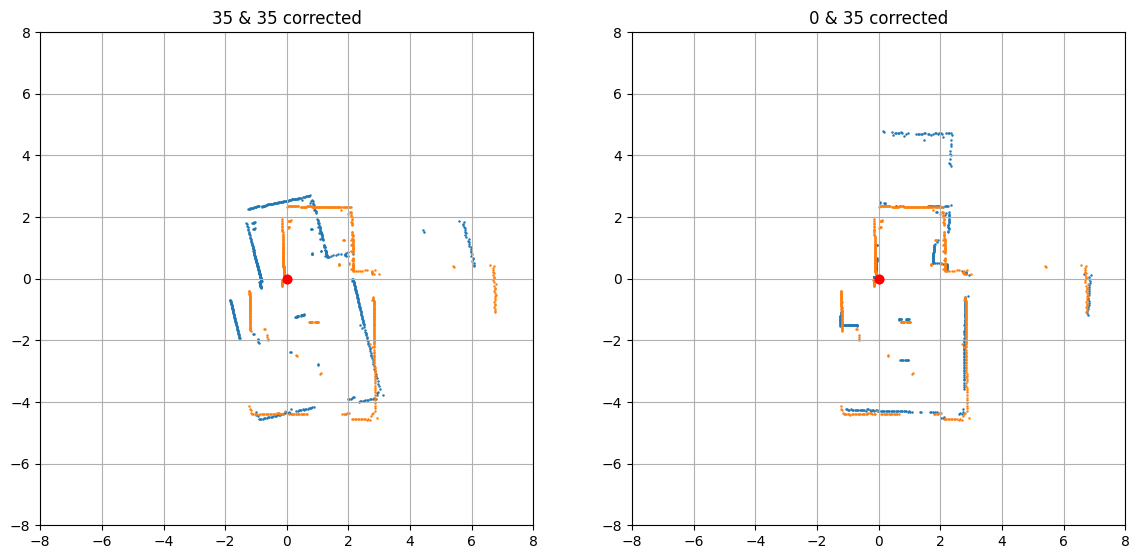

time: 344 ms (started: 2024-11-20 20:30:56 -03:00)


In [9]:
# remove time column
for i in range(len(dfs)):
    try:
        del dfs[i]['time'] 
    except:
        pass

# to numpy
scans = []
for i in range(len(dfs)):
    scans.append(dfs[i].to_numpy())

def transform(T,array):
    ones_row = np.ones((1, array.T.shape[1]))
    source_homogeneous = np.append( array.T , ones_row, axis=0)
    return T @ source_homogeneous

def correct_cloud(source_array, target_array, sor=(), icp_threshold = 3, init_trans=np.eye(4), verbose=False):
    # Pass xyz to Open3D.o3d.geometry.PointCloud
    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_array)
    if sor:
        # Statistical oulier removal
        cl, ind = target.remove_statistical_outlier(nb_neighbors=sor[0],
                                                    std_ratio=sor[1])
        target = target.select_by_index(ind)

    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_array)
    if sor:
        # Statistical oulier removal
        cl, ind = source.remove_statistical_outlier(nb_neighbors=sor[0],
                                                    std_ratio=sor[1])
        source = source.select_by_index(ind)

    # The initial state
    if verbose:
        evaluation = o3d.pipelines.registration.evaluate_registration(source, target, icp_threshold)
        print("Initial state is:")
        print(evaluation)

    # apply Open3D ICP
    reg_p2p = o3d.pipelines.registration.registration_icp(source, target, icp_threshold, init_trans)
    # if ignore_threshold:
    #     if reg_p2p.fitness < ignore_threshold[0]:
    #         print(f"\nBad fitness, {reg_p2p.fitness:.3f}<{ignore_threshold[0]} on {source_idx} to {target_idx}.")
    #         return None, None, [], []
    #     if reg_p2p.inlier_rmse > ignore_threshold[1]:
    #         print(f"\nBad RMSE, {reg_p2p.inlier_rmse:.3f}>{ignore_threshold[1]} on {source_idx} to {target_idx}.")
    #         return None, None, [], []
    if verbose:
        print("\nAfter ICP, state is:")
        print(reg_p2p)
        print("Transformation is:")
        print(reg_p2p.transformation)

    # correct
    source_corrected = transform(reg_p2p.transformation, source_array)
    return reg_p2p.fitness, reg_p2p.inlier_rmse, reg_p2p.transformation, source_corrected

source_idx, target_idx = 35, 0 
_, _, _, source_corrected = correct_cloud(scans[source_idx], scans[target_idx], verbose=True)

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10))
plot_2d(dfs[source_idx].x, dfs[source_idx].y,  "", ax1)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{source_idx} & {source_idx} corrected", ax1)
ax1.grid()

plot_2d(dfs[target_idx].x, dfs[target_idx].y, "", ax2)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{target_idx} & {source_idx} corrected", ax2)
ax2.grid()
plt.show()

#### Statistical Outlier Removal (SOR)

Initial state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=7.167023e-01, and correspondence_set size of 590
Access transformation to get result.

After ICP, state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.533665e-01, and correspondence_set size of 590
Access transformation to get result.
Transformation is:
[[ 0.97458229  0.22402983  0.          0.73304266]
 [-0.22402983  0.97458229  0.         -0.12752477]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


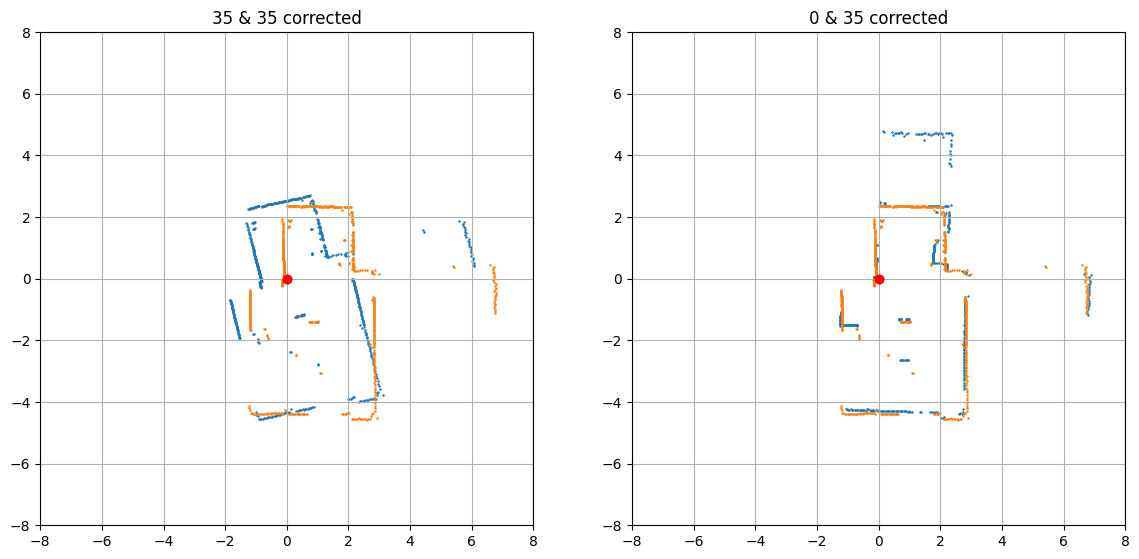

time: 281 ms (started: 2024-11-20 20:30:56 -03:00)


In [10]:
source_idx, target_idx = 35, 0 
_, _, _, source_corrected = correct_cloud(scans[source_idx], scans[target_idx], sor=(5, 2.0), verbose=True)

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10))
plot_2d(dfs[source_idx].x, dfs[source_idx].y,  "", ax1)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{source_idx} & {source_idx} corrected", ax1)
ax1.grid()

plot_2d(dfs[target_idx].x, dfs[target_idx].y, "", ax2)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{target_idx} & {source_idx} corrected", ax2)
ax2.grid()
plt.show()

#### Stack transformations

$$
\begin{bmatrix}
X_{i} \\
Y_{i} \\
Z_{i} \\
1
\end{bmatrix} = 
_{i}{\left[T\right]}_{i+1}
\begin{bmatrix}
X_{i+1} \\
Y_{i+1} \\
Z_{i+1} \\
1
\end{bmatrix} 
$$

Where:
- $_{i}{\left[T\right]}_{i+1}$ is the transformation matrix from point cloud $i+1$ to point cloud $i$.

To transform a 3D point in point cloud 2 to point cloud 0:

$$
_{0}{\left[T\right]}_{2} = _{0}{\left[T\right]}_{1} \cdot _{1}{\left[T\right]}_{2}
$$

To transform a 3D point in nth point cloud to point cloud 0:

$$
_{0}{\left[T\right]}_{n} = _{0}{\left[T\right]}_{1} \cdot _{1}{\left[T\right]}_{2} \ \dots \  _{n-1}{\left[T\right]}_{n}
$$

Initial state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.642579e-02, and correspondence_set size of 597
Access transformation to get result.

After ICP, state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.609406e-02, and correspondence_set size of 597
Access transformation to get result.
Transformation is:
[[ 9.99999744e-01 -7.15628920e-04  0.00000000e+00  2.20402273e-03]
 [ 7.15628920e-04  9.99999744e-01  0.00000000e+00  8.27349796e-04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
cloud 1 to 0: RMSE=0.016, Fit=1.000
Initial state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.337075e-02, and correspondence_set size of 598
Access transformation to get result.

After ICP, state is:
RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.287587e-02, and correspondence_set size of 598
Access transformation to get result.
Transformation is:
[

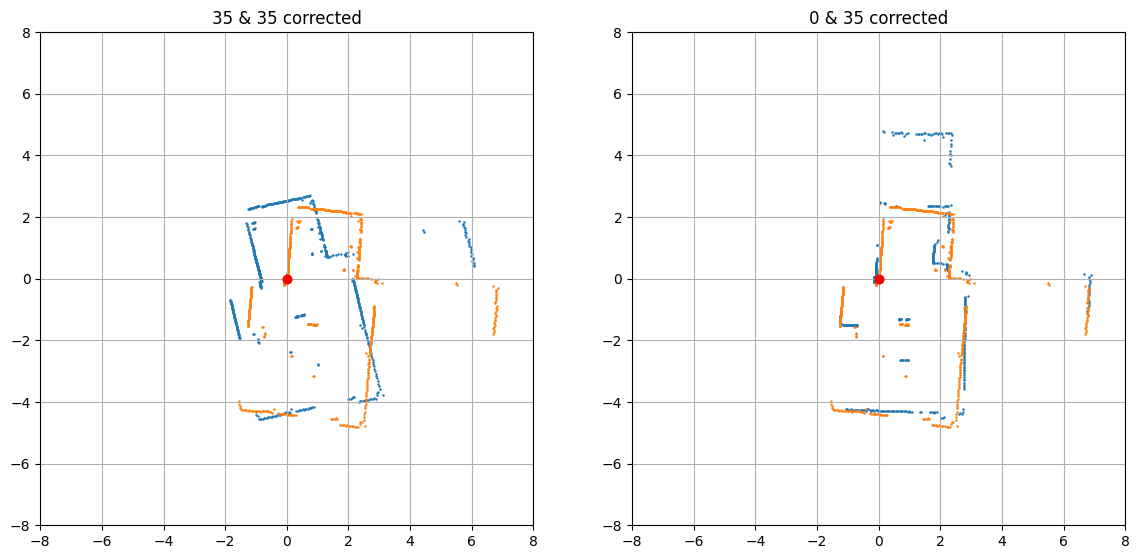

time: 375 ms (started: 2024-11-20 20:30:56 -03:00)


In [11]:
# Transform one by one and stack transformations
trans_init = np.eye(4)
init = 0
end = 35
for i in range(init,end):

    source_idx, target_idx = i+1, i 
    fitness, rmse, trans_local, source_corrected = correct_cloud(scans[source_idx], scans[target_idx], verbose=True)
    print(f"cloud {i+1} to {i}: RMSE={rmse:.3f}, Fit={fitness:.3f}")

    trans_init = trans_init @ trans_local

source_array = scans[source_idx]
source_corrected = transform(trans_init, source_array)
# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10))
plot_2d(dfs[end].x, dfs[end].y,  "", ax1)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{end} & {end} corrected", ax1)
ax1.grid()

plot_2d(dfs[init].x, dfs[init].y, "", ax2)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{init} & {end} corrected", ax2)
ax2.grid()
plt.show()

#### Apply ICP to all clouds

cloud 1 to 0: RMSE=0.016, Fit=1.000. Total Error: 0.016
cloud 2 to 1: RMSE=0.033, Fit=1.000. Total Error: 0.049
cloud 3 to 2: RMSE=0.037, Fit=1.000. Total Error: 0.086
cloud 4 to 3: RMSE=0.113, Fit=1.000. Total Error: 0.199
cloud 5 to 4: RMSE=0.025, Fit=1.000. Total Error: 0.225
cloud 6 to 5: RMSE=0.020, Fit=1.000. Total Error: 0.244
cloud 7 to 6: RMSE=0.022, Fit=0.998. Total Error: 0.266
cloud 8 to 7: RMSE=0.023, Fit=1.000. Total Error: 0.289
cloud 9 to 8: RMSE=0.025, Fit=1.000. Total Error: 0.314
cloud 10 to 9: RMSE=0.024, Fit=1.000. Total Error: 0.338
cloud 11 to 10: RMSE=0.035, Fit=1.000. Total Error: 0.372
cloud 12 to 11: RMSE=0.022, Fit=1.000. Total Error: 0.394
cloud 13 to 12: RMSE=0.116, Fit=1.000. Total Error: 0.510
cloud 14 to 13: RMSE=0.059, Fit=1.000. Total Error: 0.569
cloud 15 to 14: RMSE=0.030, Fit=1.000. Total Error: 0.599
cloud 16 to 15: RMSE=0.018, Fit=1.000. Total Error: 0.617
cloud 17 to 16: RMSE=0.019, Fit=1.000. Total Error: 0.635
cloud 18 to 17: RMSE=0.065, Fit=1

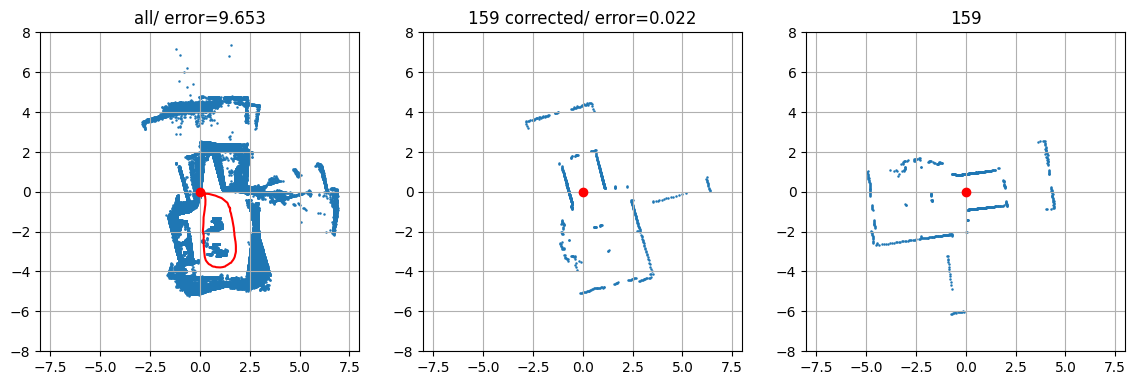

time: 1.14 s (started: 2024-11-20 20:30:57 -03:00)


In [12]:
# initialization
T = np.eye(4)
threshold = 0.2
scans_corrected = []
scans_corrected.append(scans[0])
poses = []
total_error = 0
transformations = [np.eye(4) for _ in range(len(scans))]

end = len(scans) -1 

for i in range(end):

    fitness, rmse, trans_local, source_corrected = correct_cloud(scans[i+1], scans[i], verbose=False)
    total_error +=rmse
    print(f"cloud {i+1} to {i}: RMSE={rmse:.3f}, Fit={fitness:.3f}. Total Error: {total_error:.3f}")

    T = T @ trans_local
    transformations[i+1] = T
    poses.append(T[:2,3])
    
    source_corrected = transform(T, scans[i+1])

    scans_corrected.append(source_corrected.T[:,0:3])

poses = np.array(poses)

all_corrected_scans =[]
for i in range(len(scans_corrected)):
    all_corrected_scans.extend(scans_corrected[i])
all_corrected_scans = np.array(all_corrected_scans)

fig , (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(14,10))
plot_2d(all_corrected_scans[:,0], all_corrected_scans[:,1], f"all/ error={total_error:.3f}", ax1)
ax1.plot(poses[:,0],poses[:,1], color="red")
plot_2d(scans_corrected[end][:,0], scans_corrected[end][:,1], f"{end} corrected/ error={rmse:.3f}", ax2)
plot_2d(scans[end][:,0], scans[end][:,1], end, ax3)
plt.show()

#### Check where errors started accumulating

In [13]:
# generate video
def generate_video(scans_corrected,poses):
    fig , (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(14,10))
    scatter1 = ax1.scatter([], [], s=0.6)
    head1, = ax1.plot(0, 0, 'ro')
    ln1, = ax1.plot([], [], color='red')
    ax1.set_ylim(-8, 8)
    ax1.set_xlim(-8, 8)
    ax1.set_aspect('equal')
    ax1.grid(True)
    title1 = ax1.set_title("")

    scatter2 = ax2.scatter([], [], s=0.6)
    head2, = ax2.plot(0, 0, 'ro')
    ax2.set_ylim(-8, 8)
    ax2.set_xlim(-8, 8)
    ax2.set_aspect('equal')
    ax2.grid(True)
    title2 = ax2.set_title("")

    scatter3 = ax3.scatter([], [], s=0.6)
    ax3.plot(0, 0, 'ro')
    ax3.set_ylim(-8, 8)
    ax3.set_xlim(-8, 8)
    ax3.set_aspect('equal')
    ax3.grid(True)
    title3 = ax3.set_title("")

    # Update function for animation
    all_corrected_scans2 = []
    def update(frame):
        global all_corrected_scans
        all_corrected_scans2.extend(scans_corrected[frame][:,0:2])
        scatter1.set_offsets(all_corrected_scans2)
        scatter2.set_offsets(scans_corrected[frame][:,0:2])
        scatter3.set_offsets(dfs[frame][['x', 'y']].values)
        
        title1.set_text(f"Point Cloud: all / Cloud Size: {len(all_corrected_scans2)}")
        title2.set_text(f"Cloud: {frame} corrected / Cloud size: {len(scans_corrected[frame])}")
        title3.set_text(f"Cloud: {frame} / Cloud size: {len(dfs[frame])}")

        head1.set_data([poses[frame-1, 0]], [poses[frame-1, 1]])
        ln1.set_data(poses[0:frame, 0], poses[0:frame, 1])

        head2.set_data([poses[frame-1, 0]], [poses[frame-1, 1]])
        return scatter1, scatter2, scatter3, title1, title2, title3, ln1, head1, head2

    # Create the animation
    ani = animation.FuncAnimation(
        fig, update, frames=len(scans_corrected), blit=False, repeat=False
    )

    # Save the animation as MP4
    ani.save(f'imgs/scatter_animation{sample_i}.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

    plt.close(fig)

generate_video(scans_corrected,poses)

HTML(f"""Result: <a href="imgs/scatter_animation{sample_i}.mp4">imgs/scatter_animation{sample_i}.mp4</a>""")

time: 29.9 s (started: 2024-11-20 20:30:58 -03:00)
